Zamysł tego projektu jest taki, aby wczytane zdjęcie mogło zostać zretuszowane automatycznie z użyciem sieci konwolucyjnych
w najdokładniejszym możliwym sposobie. W tym celu napisałem kilka algorytmów(na wzór tych z Photoshopa) umożliwiających manipulację zdjęciem takie jak: Białe, Czarne, Ekspozycja, Gamma, Cienie, Światła, Kontrast, Usuwanie mgły, Temperatura, Nasycenie, Odcień, Odszumianie luminancji i chrominancji(odbywa się za pomocą wytrenowanej sieci do odszumiania) oraz wyostrzanie. Idąc od góry, zdjęcie jest wczytywane, gdzie jest określany jego format pliku. Następnie zdjęcie jest wstępnie przetwarzane, aby mogło być użyte w pierwszej sieci konwolucyjnej. Sieć została wytrenowana na kilkudziesięciu przykładach, aby teraz móc z wysoką skutecznością przewidywać wszystkie wartości potrzebne do retuszu globalnego zdjęcia. Po ogólnym retuszu zdjęcie jest przetwarzane, by mogło być posegmentowane przez sieć konwolucyjną specjalnie do tego wytrenowaną. Posegmentowane części zdjęcia sa ponownie przetwarzane, aby mogły zostać użyte w kolejnej sieci prognozującej parametry do retuszu lokalnego. Ostatni etap to poskładanie i złączenie posegmentowanych kawałków w całość.


In [2]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import math
import rawpy
import tensorflow as tf
import json
import yaml
import tensorflow_addons
from skimage import exposure as exposure_ski
from skimage.metrics import structural_similarity as ssim
from skimage import restoration
from PIL import Image
from tensorflow.keras.models import load_model
plt.rcParams['figure.figsize']=24,12

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
#Wczytanie pliku, który zawiera wszystkie potrzebne ściezki do plików.
def load_config(path):
    with open(path,'r') as yamlfile:
        data=yaml.safe_load(yamlfile)
    return data
#Funkcja wczytująca zdjęcia w formacie jpg,png,nef,dng oraz zwracająca nazwę pliku.
def load_img(img_path,size=False):
    if '/' in img_path:
        img_name=img_path.split('/')[-1]
    elif '\\' in img_path:
        img_name=img_path.split('\\')[-1]
    if '.jpg' in img_path or '.png' in img_path:
        img=cv2.imread(img_path)
        return img,img_name
    elif '.NEF' in img_path or '.dng' in img_path or '.DNG' in img_path or '.nef' in img_path:
        img=rawpy.imread(img_path)
        img=img.postprocess(fbdd_noise_reduction=rawpy.FBDDNoiseReductionMode(1),chromatic_aberration=(1,1),no_auto_bright=True,dcb_enhance=True)
        img=np.array(img,np.uint8)
        img=cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        return img,img_name

#Zapisuje zdjęcie w zależności od formatu zdjęcia wejściowego
def img_saver(img_array,name_raw,path):
    name=name_raw.split('.')[0]
    img_formats=['.png','.jpg']
    if '.NEF' in name_raw or '.dng' in name_raw or '.png' in name_raw:
        img_type=img_formats[0]
    elif '.jpg' in name_raw or '.jpeg' in name_raw:
        img_type=img_formats[1]
    else:
        img_type=img_formats[1]
    cv2.imwrite(path+name+img_type,img_array)

In [4]:
#Pierwszy etap, użycie sieci do przewidzenia parametrów potrzebnych do ogólnego retuszu zdjęcia.
def predict_values(raw_img):
    model=load_model(cfg['Global_postprocess_model'])
    #Wstępne przetwarzanie
    raw_img=cv2.resize(raw_img,(384,384),interpolation=cv2.INTER_AREA)
    raw_img=tf.keras.applications.vgg16.preprocess_input(raw_img)/127.5
    raw_img=np.expand_dims(raw_img,axis=0)
    values=model.predict(raw_img)
    #Umieszczenie wyników w liście
    values_list=[]
    for i in values:
        i=i.flatten(order='C')
        values_list.append(i.tolist())  
    values_list=sum(values_list,[])
    print(values_list)
    values_list[0]=int(round(values_list[0],2)*100)
    values_list[1]=int(round(values_list[1],1)*10)
    values_list[2]=round(values_list[2],2)
    values_list[3]=round(values_list[3],2)
    values_list[4]=round(values_list[4],2)
    values_list[5]=round(values_list[5],2)
    values_list[6]=round(values_list[6],2)
    values_list[7]=round(values_list[7],2)
    values_list[8]=int(round((round(values_list[8],2)*100)*100,1))
    values_list[9]=int(round(values_list[9],2)*100)
    values_list[10]=int(round(values_list[10],2)*10)
    values_list[11]=round(values_list[11],2)
    values_list[12]=round(values_list[12],2)
    values_list[13]=round(values_list[13],2)
    return values_list
def layer_thresh(img1,img2,alpha):
    beta=(1.0-alpha)
    result=cv2.addWeighted(img1,alpha,img2,beta,0.0)
    return result
#Normalizacja czarnych pikseli mniejszych od 7 aby miały wartość 0, oraz wartości ujemnych by miały wartość 0.
def normalizer(img):
    img=np.where(img<7,0,img)
    img=np.where(img<0,0,img)
    return img
#Funkcja wyświetlająca podgląd zdjęcia.
def display_img(img):
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)

#Funkcja pozwalająca manipulować jaśniejszymi pikselami, rozjaśniając lub ściemniając
def white(img,amount=0):
    if amount==0:
        return img,amount
    else:
        img=np.float64(img)
        img[img<255]+=amount
        img=np.clip(img,0,255)
        img=np.uint8(img)
        return img, amount
#Czarne, rozjaśnia lub ściemnia czarne piksele
def black(img,amount=0):
    if amount==0:
        return img,amount
    else:
        img=np.float64(img)
        img[img<64]-=amount
        img=np.clip(img,0,255)
        img=np.uint8(img)
        return img, amount
#Symuluje sterowanie ekspozycją na zdjęciu.
def exposure_adjust(img,minimum=0):
    if minimum==0:
        return img,minimum
    else:
        h,w,c=img.shape
        brightness=1.0
        if minimum>0:
            minimum +=1.0
            ratio=brightness/minimum
            minimum -=1.0
        elif minimum<0:
            #minimum *=-1.0
            minimum +=1.0
            ratio=brightness/minimum
        img=cv2.convertScaleAbs(img,alpha=1/ratio,beta=0)
        return img,minimum
#Korekcja gamma, która pozwala zwiększyć zakres tonalny przez zwiększenie jasności w cieniach
def gamma_correction(img,gamma=0):
    if gamma==0:
        return img,gamma
    else:
        gamma_i=gamma
        gamma_i +=1
        inv_gamma=1.0/gamma_i
        imin,imax=img.min(),img.max()
        img_g=img.copy()
        img_g=((img_g-imin)/(imax-imin))**inv_gamma
        img_g=img_g*(imax-imin)+imin
        return np.uint8(img_g),gamma
#Pozwala rozjaśniać i ściemniać zarówno cienie jak i światła.
def shadow_highlights(img,
        shadow_amount_percent, shadow_tone_percent, shadow_radius,
        highlight_amount_percent, highlight_tone_percent, highlight_radius,
        color_percent):
    
    if shadow_amount_percent==0 and highlight_amount_percent==0:
        return img,shadow_amount_percent,highlight_amount_percent
    else:
        shadow_tone = shadow_tone_percent * 255
        highlight_tone = 255 - highlight_tone_percent * 255

        shadow_gain = 1 + shadow_amount_percent * 6
        highlight_gain = 1 + highlight_amount_percent * 6
        
        #Cały proces odbywa się w przestrzeni kolorystycznej YUV, gdzie  cienie/światła są edytowane w przestrzeni
        #Y(luminancji), a kolory w przestrzeni UV
        height, width = img.shape[:2]
        img = img.astype(float)
        img_R, img_G, img_B = img[..., 2].reshape(-1), img[..., 1].reshape(-1), img[..., 0].reshape(-1)
        
        #konwersja z RGB na YUV
        img_Y = .3 * img_R + .59 * img_G + .11 * img_B
        img_U = -img_R * .168736 - img_G * .331264 + img_B * .5
        img_V = img_R * .5 - img_G * .418688 - img_B * .081312
        
        #Wydobycie map cieni i świateł
        shadow_map = 255 - img_Y * 255 / shadow_tone
        shadow_map[np.where(img_Y >= shadow_tone)] = 0
        highlight_map = 255 - (255 - img_Y) * 255 / (255 - highlight_tone)
        highlight_map[np.where(img_Y <= highlight_tone)] = 0
        
        #Rozymycie na mapie tonalnej, w celu wygładzania przejścia tonalnego
        if shadow_amount_percent * shadow_radius > 0:
            shadow_map = cv2.blur(shadow_map.reshape(height, width), ksize=(shadow_radius, shadow_radius)).reshape(-1)

        if highlight_amount_percent * highlight_radius > 0:
            highlight_map = cv2.blur(highlight_map.reshape(height, width), ksize=(highlight_radius, highlight_radius)).reshape(-1)
        
        #Tabela tonalna
        t = np.arange(256)
        LUT_shadow = (1 - np.power(1 - t * (1 / 255), shadow_gain)) * 255
        LUT_shadow = np.maximum(0, np.minimum(255, np.int_(LUT_shadow + .5)))
        LUT_highlight = np.power(t * (1 / 255), highlight_gain) * 255
        LUT_highlight = np.maximum(0, np.minimum(255, np.int_(LUT_highlight + .5)))
        
        #Dostoswanie tonalne 
        shadow_map = shadow_map * (1 / 255)
        highlight_map = highlight_map * (1 / 255)

        iH = (1 - shadow_map) * img_Y + shadow_map * LUT_shadow[np.int_(img_Y)]
        iH = (1 - highlight_map) * iH + highlight_map * LUT_highlight[np.int_(iH)]
        img_Y = iH
        
        #Dostosowanie kolorów
        if color_percent != 0:
            #Tabela kolorów
            if color_percent > 0:
                LUT = (1 - np.sqrt(np.arange(32768)) * (1 / 128)) * color_percent + 1
            else:
                LUT = np.sqrt(np.arange(32768)) * (1 / 128) * color_percent + 1
            
            #Dostosowanie nasycenia kolorów w zależności od cieni i świateł
            color_gain = LUT[np.int_(img_U ** 2 + img_V ** 2 + .5)]
            w = 1 - np.minimum(2 - (shadow_map + highlight_map), 1)
            img_U = w * img_U + (1 - w) * img_U * color_gain
            img_V = w * img_V + (1 - w) * img_V * color_gain
        
        #Konwersja z YUV na RGB
        output_R = np.int_(img_Y + 1.402 * img_V + .5)
        output_G = np.int_(img_Y - .34414 * img_U - .71414 * img_V + .5)
        output_B = np.int_(img_Y + 1.772 * img_U + .5)

        output = np.row_stack([output_B, output_G, output_R]).T.reshape(height, width, 3)
        output = np.minimum(output, 255).astype(np.uint8)
        return output,shadow_amount_percent,highlight_amount_percent

#Tabela pozwalająca dostosować kontrast zdjęcia.
def edit_contrast(img,factor):
    factor +=1.0
    table=np.array([(i-74)*factor+74 for i in range(0,256)]).clip(0,255).astype('uint8')
    factor -=1.0
    return cv2.LUT(img,table),factor

#Usuwanie mgły ze zdjęcia z priorytetem na ciemny kanał ze zdjęcia. Używając tego priorytetu wraz z modelem obrazowania
#zamglenia można oszacować grubość tego zamglenia i uzyskać wysokiej jakości obrazu bez zamglenia.
def dehaze_img(img,amount):
    
    #Priorytet ciemnego kanału, konieczne jest określenie go, gdyż w prawie każdym zdjęciu chociaż jeden kanał kolorystyczny
    #ma bardzo niską intensywność w niektórych pikselach
    def dark_channel(im,s):
        b,g,r=cv2.split(im)
        dc=cv2.min(cv2.min(r,g),b)
        #Użycie erozji aby wydobyć ciemny kanał
        kernel=cv2.getStructuringElement(cv2.MORPH_RECT,(s,s))
        dark=cv2.erode(dc,kernel)
        return dark
    #Oszacowanie jasności światała atmosferycznego
    def AtmLight(im,dark):
        [h,w]=im.shape[:2]
        ims=h*w
        #Wybranie 0.1% najaśniejszych pikseli w ceimnym kanale oraz pikseli o największej intensywności na całym zdjęciu.
        num_px=int(max(math.floor(ims/1000),1))
        dark_vec=dark.reshape(ims)
        im_vec=im.reshape(ims,3)
        indices=dark_vec.argsort()
        indices=indices[ims-num_px::]

        atmsum=np.zeros([1,3])
        for ind in range(1,num_px):
            atmsum=atmsum+im_vec[indices[ind]]
        A=atmsum/num_px
        return A
    #Oszacowanie transmisji
    def TransmissionEstimate(im,A,s):
        omega=0.95
        im3=np.empty(im.shape,im.dtype)

        for ind in range(0,3):
            im3[:,:,ind]=im[:,:,ind]/A[0,ind]

        transmission=1-omega*dark_channel(im3,s)
        return transmission
    
    #Oszacowanie i użycie filtra do wygłądzania z zachowaniem krawędzi oraz udoskonalenia transmisji
    def guided_filter(im,im_p,r,eps):
        mean_I=cv2.boxFilter(im,cv2.CV_64F,(r,r))
        mean_p=cv2.boxFilter(im_p,cv2.CV_64F,(r,r))
        mean_Ip=cv2.boxFilter(im*im_p,cv2.CV_64F,(r,r))
        cov_Ip=mean_Ip-mean_I*mean_p

        mean_II=cv2.boxFilter(im*im,cv2.CV_64F,(r,r))
        var_I=mean_II-mean_I*mean_I

        a=cov_Ip/(var_I+eps)
        b=mean_p-a*mean_I

        mean_a=cv2.boxFilter(a,cv2.CV_64F,(r,r))
        mean_b=cv2.boxFilter(b,cv2.CV_64F,(r,r))

        q=mean_a*im+mean_b
        return q
    
    def TransmissionRefine(im,et):
        gray=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
        gray=np.float64(gray)/255
        r=60
        eps=0.0001
        t=guided_filter(gray,et,r,eps)
        return t
    #Odtworzenie luminancji sceny z pomocą mapy transmisji
    def Recover(im,t,A,tx=0.1):
        res = np.empty(im.shape,im.dtype)
        t = cv2.max(t,tx)

        for ind in range(0,3):
            res[:,:,ind]=(im[:,:,ind]-A[0,ind])/t+A[0,ind]
        return res
    
    if amount==0:
        return img,amount
    else:
        img64=img.astype('float64')/255
        x=dark_channel(img64,15)
        A=AtmLight(img64,x)
        te=TransmissionEstimate(img64,A,15)
        t=TransmissionRefine(img,te)
        J=Recover(img64,t,A,0.1)
        J=J*255
        J=np.clip(J,0,255)
        J=np.uint8(J)
        J_layer=layer_thresh(J,img,amount)
        return J_layer,amount


#Funkcja umożliwiająca zmianę temperatury barwowej zdjęcia
def convert_temp(img,temp):
    if temp==0:
        return img,temp
    else:
        r,g,b=cfg['kelvin_table'][temp]
        matrix=(r/255.0,0.0,0.0,0.0,
               0.0,g/255.0,0.0,0.0,
               0.0,0.0,b/255.0,0.0)
        img=Image.fromarray(img)
        img=img.convert('RGB',matrix)
        img=np.array(img,np.uint8)
        return img,temp
#Funckja pozwalająca zwiększyć lub zmniejszyć nasycenie kolorów na zdjęciu.
def edit_saturation(img,amount):
    if amount==0:
        return img,amount
    else:
        hsv=cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
        hsv[:,:,1]=hsv[:,:,1]+amount
        hsv[:,:,1][hsv[:,:,1]>255]=255
        hsv[:,:,1][hsv[:,:,1]<0]=0
        hsv=cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
        return hsv,amount
#Edycja docienia zielony/karamzynowy
def edit_tint(img,amount):
    if amount==0:
        return img,amount
    else:
        img=np.int16(img)
        img[:,:,1]=img[:,:,1]+amount
        img=np.clip(img,0,255)
        img=np.uint8(img)
        return img,amount
#Oduszmianie non-local means(średnie nielokalne) przeznaczone tylko do odszumiana posegmentowanych fragmentów.
def denoise_img(img,amount):
    if amount==0:
        return img,amount
    else:
        img_denoised=img.astype('float64')/255
        #img_denoised=restoration.denoise_wavelet(img_denoised,wavelet='rbio2.6',mode='soft',multichannel=True,wavelet_levels=3,convert2ycbcr=True,method='BayesShrink')
        img_denoised=restoration.denoise_nl_means(img_denoised,channel_axis=-1,preserve_range=True,patch_size=3,patch_distance=3)
        img_denoised=img_denoised*255
        img_denoised=np.clip(img_denoised,0,255)
        img_denoised=np.uint8(img_denoised)
        add=layer_thresh(img_denoised,img,amount)
        return add,amount

#Funkcja która łączy podzielone zdjęcie w całość
def img_concat(img_patches):
    l=[]
    temp=[]
    amount=len(img_patches)
    for i in range(amount):
        horizontal_patches=img_patches[i]
        temp.append(horizontal_patches)
        if i%2==1:
            horizontal=np.concatenate((temp),axis=1)
            l.append(horizontal)
            temp=[] 
    vertical=np.concatenate((l),axis=0)
    return vertical
#Funkcja zwracająca podzielone zdjęcie na 4 fragmenty
def img_patcher(img,num_patches='4',d=True):
    #img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    h,w,c=img.shape
    if d:
        h=div_check(h)
        w=div_check(w)
        img=cv2.resize(img,(w,h),interpolation=cv2.INTER_AREA)
    h,w,c=img.shape
    if num_patches=='4':
        patch1=img[0:int(h/2),0:int(w/2)]
        patch2=img[0:int(h/2),int(w/2):w]
        patch3=img[int(h/2):h,0:int(w/2)]
        patch4=img[int(h/2):h,int(w/2):w]
        return patch1,patch2,patch3,patch4
    else:
        return img
#Sprawdzanie czy wymiary zdjęcia są podzielne przez 5
def div_check(x):
    while True:
        if int(x)%32==0:
            return x
            break
        else:
            x=x-1
#Odszumianie wytrenowaną siecią konwolucyjną wzorowaną na architekturze PRIDNet, osiąga lepsze wyniki niż tradycyjne metody
#W celu przyspieszenia procesu odszumiania oraz zredukowania użycia zasobów sprzętowych zdjęcie jest dzielone na cztery 
#równe fragmenty, więcej szczegółow w osobnym pliku.
def denoise_ai_img(img,amount=0):
    #Odszumianie zdjęcia
    def predict(img):
        t=img_patcher(img,num_patches='4')
        t=np.array(t,dtype=np.float32)/255
        pred_patches=[]
        for im in t:
            img=np.expand_dims(im,axis=0)
            img_pred=generator.predict(img)
            pred_patches.append(img_pred)
        score=np.array(pred_patches)
        score=score[:,0,:,:,:]
        score=(score*255).astype('uint8')
        score=img_concat(score)
        return score 
    if amount==0:
        return img,amount
    else:
        generator=load_model(cfg['Denoising_model'],compile=False)
        denoised=predict(img)
        img=cv2.resize(img,(denoised.shape[1],denoised.shape[0]),interpolation=cv2.INTER_AREA)
        mix=layer_thresh(denoised,img,amount)
        return mix,amount
#Oduszmianie chrominancji(szumu kolorowego), z użyciem nieliniowego filtra dwustronnego(bilateral filter) w przestrzeni
#kolorsytycznej HSV
def color_denoise(img_array,amount):
    if amount==0:
        return img_array,amount
    else:
        img=cv2.cvtColor(img_array,cv2.COLOR_BGR2HSV)
        img[:,:,0]=cv2.bilateralFilter(img[:,:,0],50,55,180)
        img[:,:,1]=cv2.bilateralFilter(img[:,:,1],40,150,150)
        img[:,:,2]=cv2.bilateralFilter(img[:,:,2],30,4,4)
        img=cv2.cvtColor(img,cv2.COLOR_HSV2BGR)
        add=layer_thresh(img,img_array,amount)
        return add,amount
#Wyostrzanie z użyciem splotu funkcji(konwolucji), dwoma różnymi filtrami Laplace'a przeznaczonymi do wykrywania krawędzi.
def sharpen_img(img_array,amount):
    if amount==0:
        return img,amount
    else:
        img=np.float64(img_array)/255
        #Filtr Laplace'a
        kernel1=np.array([[ 0.,  1.,  0.],[ 1., -4.,  1.],[ 0.,  1.,  0.]],np.float32)
        sharpen1=cv2.filter2D(img,cv2.CV_64F,kernel1)
        sharpen1=np.abs(img-sharpen1)
        sharpen1[sharpen1>1.0]=1.0
        sharpen1[sharpen1<0.0]=0.0
        sharpen1=(sharpen1*255).astype(np.uint8)
        #Silny filtr Laplace'a
        kernel2=np.array([[-1., -1., -1.],[-1.,  8., -1.],[-1., -1., -1.]],np.float32)
        sharpen2=cv2.filter2D(img,cv2.CV_64F,kernel2)
        sharpen2=np.abs(img+sharpen2)
        sharpen2[sharpen2>1.0]=1.0
        sharpen2[sharpen2<0.0]=0.0
        sharpen2=(sharpen2*255).astype(np.uint8)
        add_sharpened=layer_thresh(sharpen1,sharpen2,0.5)
        final_sharpen=layer_thresh(add_sharpened,img_array,amount)
        return final_sharpen,amount
#Funkcja odpowiadająca za interpolacje zdjęcia 2-krotnie lub 4-krotnie z użyciem wytrenowanej sieci SRGAN.    
def SRGAN_upscale(img_array):
    #W celu zachowania kolorów, histogram obrazu przed interpolacją jest nakładany na obraz wyjściowy z modelu
    def histogram_match(img1,img2):
        y,x,c=img2.shape
        img1=cv2.resize(img1,(x,y),interpolation=cv2.INTER_CUBIC)
        matched=exposure_ski.match_histograms(img2,img1,channel_axis=-1)
        return matched
    
    def load_sr(mode='2x'):
        if mode=='4x':
            gan=load_model(cfg['srgen_4x'],compile=False)
        else:
            gan=load_model(cfg['srgen_2x'],compile=False)
        return gan
    #Dzielenie zdjęcia na cztery równe części jak w przypadku wyżej
    def upscale(img,generator):
        t=img_patcher(img,num_patches='4',d=False)
        t=np.array(t,dtype=np.float32)/127.5-1
        pred_patches=[]
        with tf.device('/CPU:0'):
            for im in t:
                img=np.expand_dims(im,axis=0)
                img_pred=generator.predict(img)
                pred_patches.append(img_pred)
        score=np.array(pred_patches)
        score=score[:,0,:,:,:]
        score=((score+1)*127.5).astype('uint8')
        score=img_concat(score)
        mix=histogram_match(img_array,score)
        return mix
    #Ustalenie wymiarów dla których mają zostać użyte odpowiednie wersje sieci SRGAN
    def shape_check(img_array):
        h,w,c=img_array.shape
        if w<=1500 and h<=1000:
            gen=load_sr('4x')
            image=upscale(img_array,gen)
            return image
        elif w>=1500 and w<=3000 and h>=1000 and h<=2000:
            gen=load_sr('2x')
            image=upscale(img_array,gen)
            return image
        else:
            return img_array
    return shape_check(img_array)
    

In [5]:
#Funkcja do przycinania fragmentów zdjęcia, z czarnych obramówek.
def crop_img(img):
    indx=np.where(img>0)
    indx=np.array(indx)
    px_coords=list(zip(indx[0],indx[1]))
    px_coords=np.array(px_coords)
    y=px_coords[:,0]
    x=px_coords[:,1]
    ymin=y.min()
    ymax=y.max()
    xmin=x.min()
    xmax=x.max()
    crop=img[ymin:ymax,xmin:xmax]
    return crop
#Drugi etap czyli segmentowanie zdjęcia na 12 różnych klas. Zdjęcie jest przetwarzane i użyte w sieci konwolucyjnej
#o architekturze wzorowanej na DeepLabV3+, gdzyż jest znacznie wydajeniejsza i skuteczniejsza niż tradycyjny U-net.
def predict_mask(img):
    model=load_model(cfg['Mask_model'],compile=False)
    img_to_pred=cv2.resize(img,(800,608),interpolation=cv2.INTER_AREA)
    img_to_pred=tf.keras.applications.resnet50.preprocess_input(img_to_pred)/127.5
    img_to_pred=np.expand_dims(img_to_pred,axis=0)
    predicted_mask=model.predict(img_to_pred)
    predicted_mask=predicted_mask[0,:,:,:]
    predicted_mask_hq=cv2.resize(predicted_mask,(img.shape[1],img.shape[0]),interpolation=cv2.INTER_LINEAR)
    predicted_mask=np.argmax(predicted_mask,axis=2,keepdims=True)
    predicted_mask_hq=np.argmax(predicted_mask_hq,axis=2,keepdims=True)
    return predicted_mask,predicted_mask_hq

#W tej funkcji jest wydobywanie koordynatów pikseli z maski, aby móc ten fragment zaznaczyć ze zdjęcia do obróbki. Wszystkie
#te fragmenty które mają odpowiednią wielkość są zaznaczane i wybierane do dalszej obróbki.
def segmented_img_to_predict(imgf,img_mask):
    img=cv2.resize(imgf,(800,608),interpolation=cv2.INTER_AREA)
    segmented_parts=[]
    coords_list=[]
    class_list=[]
    classes=np.unique(img_mask)
    #pobieranie informacji o klasach na posegmentowanym zdjęciu
    for i in classes:
        indx=np.where(img_mask==i)
        indx=np.array(indx)
        coords=list(zip(indx[0],indx[1]))
        #Jeśli mają wystarczającą powierzchnie są dodawane do tablicy wypłenionej zerami
        if sum(indx[1].shape)>5000:
            img_slice=np.zeros(img.shape)
            for pixels in coords:
                img_slice[pixels]=img[pixels]
            segmented_parts.append(np.uint8(img_slice))
            coords_list.append(coords)
            class_list.append(i)
    return np.array(segmented_parts),coords_list,class_list
#Ta funkcja ma dokładnie identycznie zadanie co ta wyżej, jedyna różnica to przyjmuje zdjęcia o dowolnej wielkości,
#a jest to spowodowane tym że sieć do segmentacji przyjmuje wymiary 800x608
def segmented_img_to_postprocess(imgf,img_mask):
    segmented_parts=[]
    coords_list=[]
    #class_list=[]
    classes=np.unique(img_mask)
    for i in classes:
        indx=np.where(img_mask==i)
        indx=np.array(indx)
        coords=list(zip(indx[0],indx[1]))
        thr=int((imgf.shape[0]*imgf.shape[1])/(800*608))
        if sum(indx[1].shape)>5000*thr:
            img_slice=np.zeros(imgf.shape)
            for pixels in coords:
                img_slice[pixels]=imgf[pixels]
            segmented_parts.append(np.uint8(img_slice))
            coords_list.append(coords)
            #class_list.append(i)
    return np.array(segmented_parts),coords_list#,class_list
#Jest to ostatni etap, w którym wybrane fragmenty zdjęcia są lokalnie retuszowane parametrami dobranymi przez kolejną sieć 
#konwolucyjną, wytrenowaną na setkach przykładów.
def predict_segmented_values(segmented_imgs):
    local_predicted=[]
    model=load_model(cfg['Local_postprocess_model'])
    for i in segmented_imgs:
        i=crop_img(i)
        i=tf.keras.applications.vgg16.preprocess_input(i)/127.5
        i=np.expand_dims(i,axis=0)
        out=model.predict(i)
        out=np.array(out)
        out=out[:,:,0]
        local_predicted.append(out.tolist())
    #Zaokrąglanie i przetwarzanie wartośći przewidzianych przez sieć
    for v in range(len(local_predicted)):
        local_predicted[v]=sum(local_predicted[v],[])
        local_predicted[v][0]=int(round(local_predicted[v][0],2)*10)
        local_predicted[v][1]=int(round(local_predicted[v][1],1)*10)
        local_predicted[v][2]=round(local_predicted[v][2],2)
        local_predicted[v][3]=round(local_predicted[v][3],2)
        local_predicted[v][4]=round(local_predicted[v][4],2)
        local_predicted[v][5]=round(local_predicted[v][5],2)
        local_predicted[v][6]=round(local_predicted[v][6],2)
        local_predicted[v][7]=round(local_predicted[v][7],2)
        local_predicted[v][8]=int(round((round(local_predicted[v][8],2)*100)*100,1))
        local_predicted[v][9]=int(round(local_predicted[v][9],2)*10)
        local_predicted[v][10]=int(round(local_predicted[v][10],2)*10)
        local_predicted[v][11]=round(local_predicted[v][11],2)
        local_predicted[v][12]=round(local_predicted[v][12],2)
        local_predicted[v][13]=round(local_predicted[v][13],2)
    return local_predicted
#Retusz fragmentów zdjęć 
def postprocess_local(segmented_hq_imgs,value):
    postprocessed_slices=[]
    for ind in range(len(segmented_hq_imgs)):
        image=segmented_hq_imgs[ind]
        image,whites=white(image,value[ind][0])
        image,blacks=black(image,value[ind][1])
        image,exposure=exposure_adjust(image,value[ind][2])
        image,gamma=gamma_correction(image,value[ind][3])
        image,shadows,highlights=shadow_highlights(image,value[ind][4],0.4,15,value[ind][5],0.4,1,-0.1)
        image,contrast=edit_contrast(image,value[ind][6])
        image,dehaze=dehaze_img(image,value[ind][7])
        image,kelvin=convert_temp(image,value[ind][8])
        image,saturation=edit_saturation(image,value[ind][9])
        image,tint=edit_tint(image,value[ind][10])
        image,denoise=denoise_img(image,value[ind][11])
        image,color_noise=color_denoise(image,value[ind][12])
        image,sharpen=sharpen_img(image,value[ind][13])
        postprocessed_slices.append(image)
    return postprocessed_slices
#Aby efekty były widoczne na zdjęciu wejściowym, w tej funkcji zretuszowane fragmenty zdjęć są wklejane w zdjęcie główne.
def paste_slices(img,img_slices,coords):
    img_p=img.copy()
    for indx,im in enumerate(img_slices):
        for pixels in coords[indx]:
            img_p[pixels]=im[pixels]
    return img_p
#W celu zmniejszenia widoczności krawędzi wklejonego fragmentu do zdjęcia głównego które często się różnią jakościowo,
#trzeba zastosować wygładzanie. Ta funkcja wyszukuje krawędzie fragmentów zdjęć i zapisuje ich koordynaty
def edges(segmented_imgs,img):
    all_lines=[]
    line_coords=[]
    for l in range(len(segmented_imgs)):
        img_slice=np.uint8(segmented_imgs[l])
        img_g=cv2.cvtColor(img_slice,cv2.COLOR_RGB2GRAY)
        img_blur=cv2.GaussianBlur(img_g,(3,3),0)
        canny=cv2.Canny(img_blur,100,300)
        canny=cv2.blur(canny,ksize=(11,11))
        canny=np.where(canny>0,255,canny)
        indxs=np.where(canny==255)
        lines=list(zip(indxs[0],indxs[1]))
        white_lines=np.zeros(img.shape)
        for pixels in lines:
            white_lines[pixels]=img[pixels]
        all_lines.append(white_lines)
        line_coords.append(lines)
    return np.array(all_lines),line_coords
#Krawędzie zdjęcia wejściowego są wklejane w krawędzie fragmentów i są mieszane
def smoothing(img,img_postpr,img_edges,pixel_cords,alpha=0.5):
    img_n=img_postpr.copy()
    for indx,im in enumerate(img_edges):
        img_post=np.zeros(img_n.shape)
        for pixel in pixel_cords[indx]:
            img_post[pixel]=img_postpr[pixel]
        img_blended=cv2.addWeighted(img_post,alpha,img_edges[indx],1.0-alpha,0)
        for pixel2 in pixel_cords[indx]:
            img_n[pixel2]=img_blended[pixel2]
    return img_n

In [6]:
cfg=load_config('C:/Users/komej/Desktop/AutoEnhancer/config.yaml')
image_unprocessed,img_name=load_img(r"C:\Users\komej\Desktop\AutoEnhancer\to_process\_DSC1169.NEF")
value=predict_values(image_unprocessed)
image0,whites=white(image_unprocessed,value[0])
image1,blacks=black(image0,value[1])
image2,exposure=exposure_adjust(image1,value[2])
image3,gamma=gamma_correction(image2,value[3])
image4,shadows,highlights=shadow_highlights(image3,value[4],0.4,15,value[5],0.4,15,-0.1)
image5,contrast=edit_contrast(image4,value[6])
image6,dehaze=dehaze_img(image5,value[7])
image7,kelvin=convert_temp(image6,value[8])
image8,saturation=edit_saturation(image7,value[9])
image9,tint=edit_tint(image8,value[10])
image10,denoise=denoise_ai_img(image9,value[11])
image11,color_noise=color_denoise(image10,value[12])
image12,sharpen=sharpen_img(image11,value[13])
image12=normalizer(image12)
#display_img(image12)

[0.03146195411682129, -0.08020154386758804, 0.45920413732528687, 0.36415740847587585, 0.10893765091896057, 0.06982265412807465, 0.042793259024620056, 0.03006599098443985, 0.5659230947494507, 0.06891433149576187, -0.1589633673429489, 0.39476627111434937, 0.3283948302268982, 0.2707441747188568]
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070, compute capability 8.6


In [55]:
#img_saver(image12,img_name,'C:/Users/komej/Desktop/AutoEnhancer/')

In [7]:
cfg=load_config('C:/Users/komej/Desktop/AutoEnhancer/config.yaml')
mask,mask_hq=predict_mask(image12)
segmented_imgs,coords_lr,class_list=segmented_img_to_predict(image12,mask)
segmented_hq,coords_hq=segmented_img_to_postprocess(image12,mask_hq)
values=predict_segmented_values(segmented_imgs)
slices=postprocess_local(segmented_hq,values)
img_pasted=paste_slices(image12,slices,coords_hq)
edges_detection,line_coords=edges(segmented_hq,image12)
final_img=smoothing(image12,img_pasted,edges_detection,line_coords,0.5)
ups=SRGAN_upscale(final_img)
#display_img(ups)

In [8]:
img_saver(ups,img_name,'C:/Users/komej/Desktop/AutoEnhancer/')

In [44]:
def compare(img_pr,raw_img):
    img_pr=cv2.cvtColor(img_pr,cv2.COLOR_BGR2RGB)
    raw_img=cv2.cvtColor(raw_img,cv2.COLOR_BGR2RGB)
    fig,axs=plt.subplots(2,1,figsize=(25,25))
    axs[0].imshow(raw_img)
    axs[0].set_title('Zdjęcie wejściowe')
    axs[1].imshow(img_pr)
    axs[1].set_title('Zdjęcie zretuszowane')

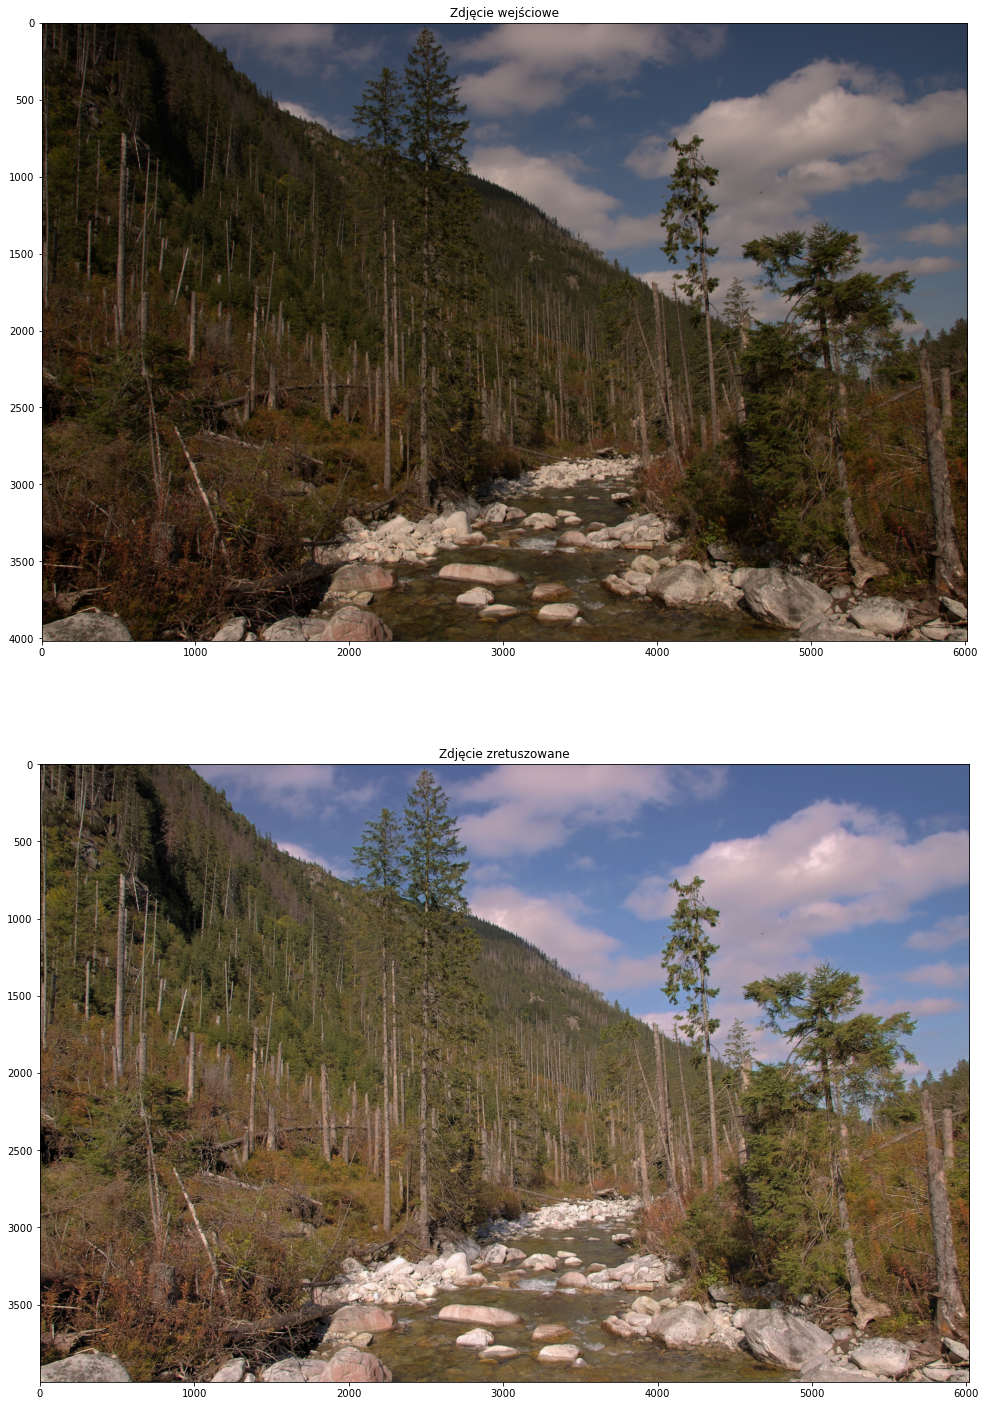

In [45]:
compare(ups,image_unprocessed)

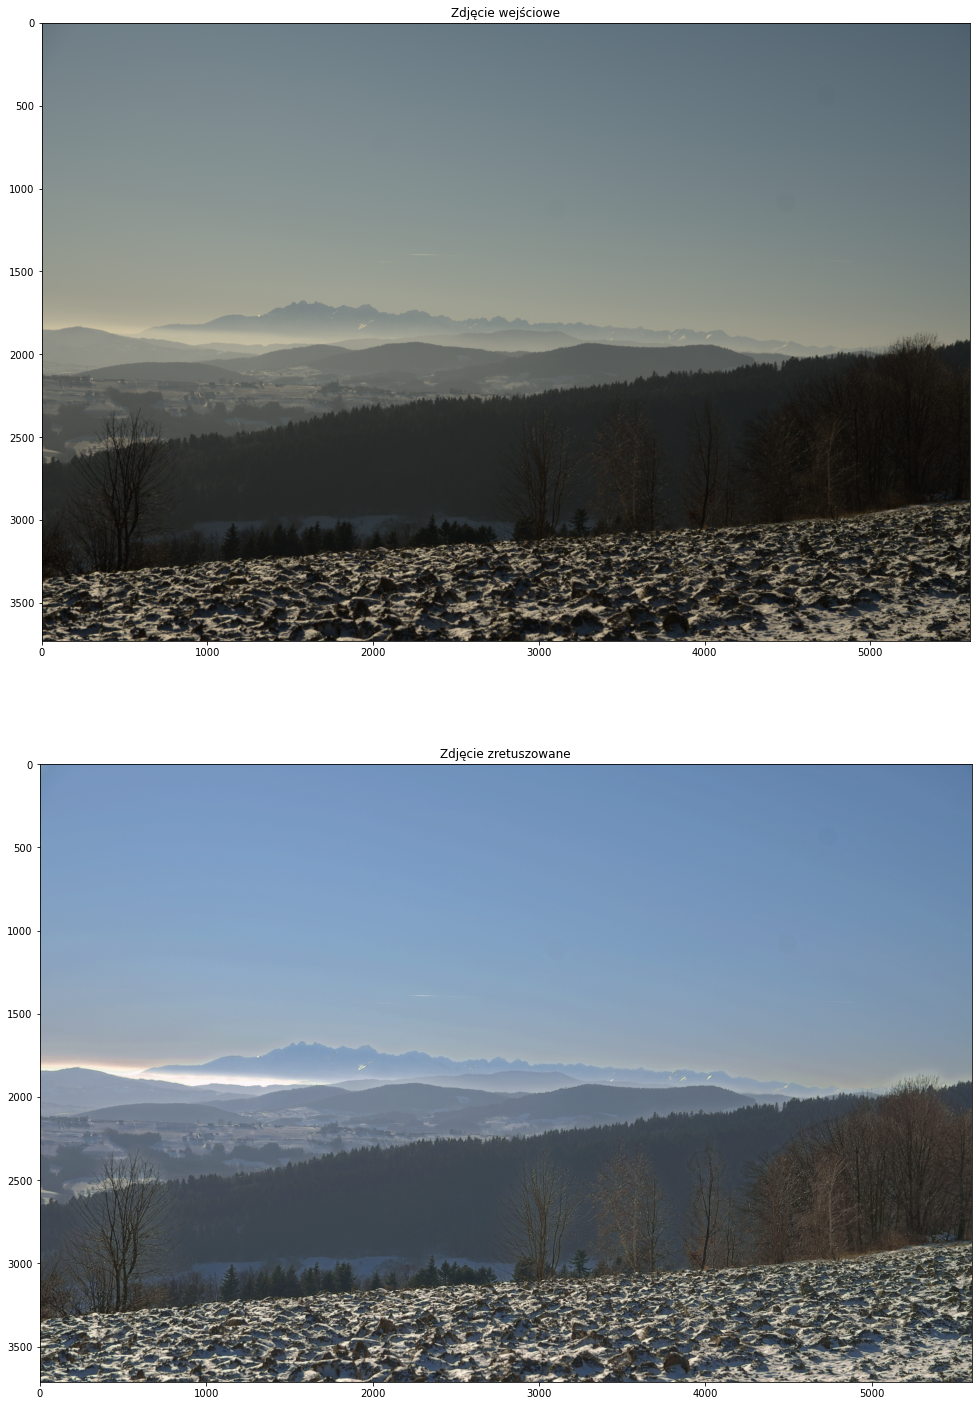

In [53]:
compare(ups,image_unprocessed)

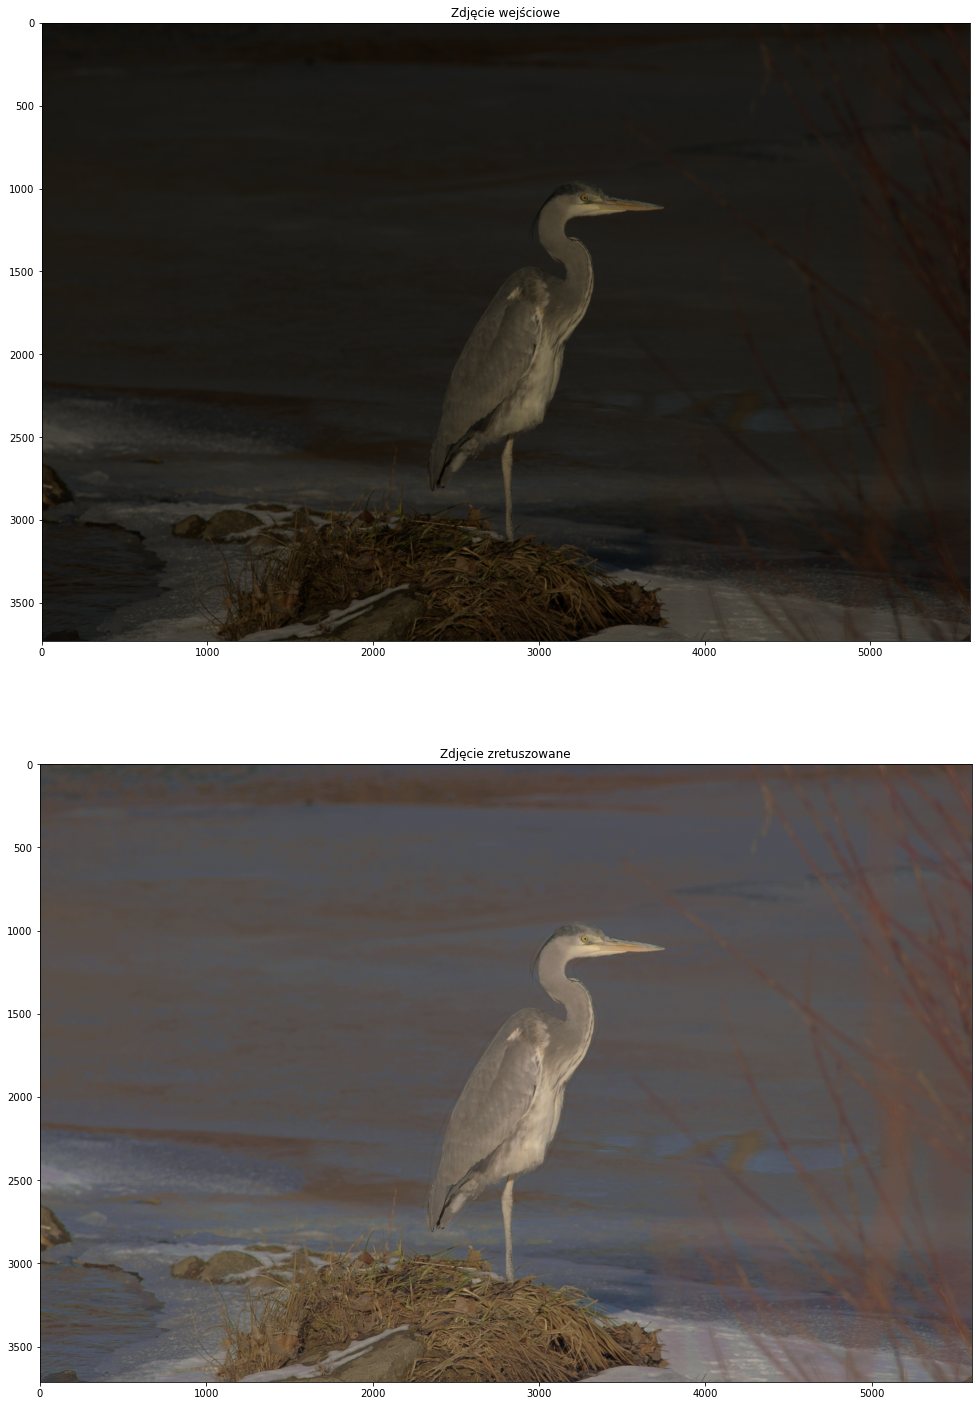

In [58]:
compare(ups,image_unprocessed)

Jak widać na porównaniu efekt końcowy jest całkiem dobry. Jest kilka niedociągnięć, które trzeba poprawić takie jak nieprawidłowe przewidywanie maski do zdjęcia, czy błędne parametry do retuszu pogaraszające efekt końcowy. Pomóc powinno zwiększenie zbiorów treningowych do sieci odpowiadających za segmentację zdjęcia oraz dobór parametrów do retuszu.